<a href="https://colab.research.google.com/github/mineramc/GTSRB_image_recognition/blob/master/GTSRB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data from kaggle

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine. Load this file to content folder in colab

3. Go to your Google Colab project file and run the following commands:

In [16]:
! pip install kaggle;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [18]:
! cp kaggle.json ~/.kaggle/

In [19]:
! chmod 600 ~/.kaggle/kaggle.json

In [20]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 96% 589M/612M [00:02<00:00, 254MB/s]
100% 612M/612M [00:02<00:00, 243MB/s]


In [21]:
! mkdir data

mkdir: cannot create directory ‘data’: File exists


In [22]:
! unzip gtsrb-german-traffic-sign.zip -d data > /dev/null 2>&1

# Steps to set up CNN

1. Collect training data
2. Shuffle training data and normalize data
3. Split train and validation data
4. One hot encoding labels (categorical data)
5. Make model
6. Augment data and train model
7. Evaluate model
8. Load test data and run predictions
9. Visualize Confusion Matrix
10. Classification Report
11. Prediction on Test Data

# import libraries and set global variables

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
import tensorflow as tf
import os
import cv2

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from PIL import Image, ImageOps

In [99]:
NUM_CLASSES = 43
IMG_HEIGHT = 32
IMG_WIDTH = 32

DATA_DIR = "/content/data"

1. Load training data

In [100]:
train_csv = os.path.join(DATA_DIR, "Train.csv")
train_df = pd.read_csv(train_csv)
train_df.head()

greyscale_crop_train_data = []
crop_train_data = []
greyscale_train_data = []
train_data = []
train_labels = np.array(train_df['ClassId'])

for _, row in train_df.iterrows():
  img_path = os.path.join(DATA_DIR, row['Path'])
  try:
    img_arr = cv2.imread(img_path)
    img = Image.fromarray(img_arr, 'RGB')


    # Original data and greyscaled version of normal data
    resize_image = img.resize((IMG_HEIGHT, IMG_WIDTH))
    greyscale_image = ImageOps.grayscale(resize_image)
    train_data.append(np.array(resize_image))
    greyscale_train_data.append(np.array(resize_image))


    # Crop images based on Roi.X, Roi.Y
    # PIL's Image.crop() expects it in (left, upper, right, lower)
    # Roi.X1 / Y1 are upper left, Roi.X2 / Y2 are lower right
    cropped_img = img.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
    resize_image = cropped_img.resize((IMG_HEIGHT, IMG_WIDTH))
    greyscale_image = ImageOps.grayscale(resize_image)
    crop_train_data.append(np.array(resize_image))
    greyscale_crop_train_data.append(np.array(greyscale_image))

    
  except:
    print("Error with importing image.")

crop_train_data = np.array(crop_train_data)
greyscale_crop_train_data = np.array(greyscale_crop_train_data)
train_data = np.array(train_data)
greyscale_train_data = np.array(greyscale_train_data)

print("Cropped Testing Data Shape:", crop_train_data.shape)
print("Cropped Greyscale Testing Data Shape:", greyscale_crop_train_data.shape)
print("Testing Data Shape:", train_data.shape)
print("Greyscale Testing Data Shape:", greyscale_train_data.shape)
print("Training Label Shape:", train_labels.shape)


Cropped Testing Data Shape: (39209, 32, 32, 3)
Cropped Greyscale Testing Data Shape: (39209, 32, 32)
Testing Data Shape: (39209, 32, 32, 3)
Greyscale Testing Data Shape: (39209, 32, 32, 3)
Training Label Shape: (39209,)


2. Shuffle training data and normalize

In [101]:
shuffle_indexes = np.arange(train_labels.shape[0]) #return numpy array [0,1,2,...,39206,39207,39208]
# image_data.shape = (39209, 30, 30, 3)
rng = np.random.default_rng()
rng.shuffle(shuffle_indexes)
np.random.shuffle(shuffle_indexes) # shuffles index

# shuffles the data with shuffled indices
image_data = train_data[shuffle_indexes]
image_labels = train_labels[shuffle_indexes]
grey_data = greyscale_train_data[shuffle_indexes]

X = image_data/255
y = image_labels
grey_X_train = grey_data/255



3. Training and validation split

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

4. One hot encoding labels

In [103]:
print("Shape before one-hot encoding:", y_train.shape, y_val.shape)

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

print("Shape after one-hot encoding:", y_train.shape, y_val.shape)

Shape before one-hot encoding: (31367,) (7842,)
Shape after one-hot encoding: (31367, 43) (7842, 43)


5. Making the model



> Sequential model is used for a plain stack of layers where each layer has exactly one input and output tensor.

> Dropouts are used to prevent overfitting. A technique where randomly selected neurons are dropped out.

*   use small of 20% to 50%
*   use larger networks since dropout works better on larger networks
* Use Dropout on incoming (visible) as well as hidden units. Application of Dropout at each layer of the network has shown good results.
* use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
* Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights, such as max-norm regularization, with a size of 4 or 5 has been shown to improve results.

In [171]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.15),
  layers.RandomTranslation(0.1, 0.1)
])

model = Sequential()
# Data Augmentation layers
# model.add(data_augmentation)
# CNN layer 1
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=-1))
#model.add(Dropout(rate=0.2)) # added dropout


# CNN layer 2
model.add(Conv2D(filters=50, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(Conv2D(filters=50, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.01))
keras.layers.BatchNormalization()
model.add(Dropout(rate=0.65))
model.add(Dense(43, activation='softmax'))

In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [173]:
model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_54 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                    

6. Train model

In [174]:
epochs=30
history = model.fit(
  x = X_train,
  y = y_train,
  batch_size=32, # number of training examples used in one epoch 
  validation_data=(X_val, y_val),
  epochs=epochs # epoch is one complete pass through training data
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


981/981 [==============================] - 7s 7ms/step - loss: 0.7779 - accuracy: 0.7947 - val_loss: 0.0553 - val_accuracy: 0.9847
Epoch 2/30
981/981 [==============================] - 5s 6ms/step - loss: 0.1409 - accuracy: 0.9568 - val_loss: 0.0639 - val_accuracy: 0.9841
Epoch 3/30
981/981 [==============================] - 5s 5ms/step - loss: 0.0954 - accuracy: 0.9724 - val_loss: 0.0404 - val_accuracy: 0.9898
Epoch 4/30
981/981 [==============================] - 5s 6ms/step - loss: 0.0980 - accuracy: 0.9722 - val_loss: 0.0669 - val_accuracy: 0.9815
Epoch 5/30
981/981 [==============================] - 5s 6ms/step - loss: 0.0709 - accuracy: 0.9809 - val_loss: 0.0244 - val_accuracy: 0.9927
Epoch 6/30
981/981 [==============================] - 5s 6ms/step - loss: 0.0657 - accuracy: 0.9807 - val_loss: 0.0349 - val_accuracy: 0.9897
Epoch 7/30
981/981 [==============================] - 6s 6ms/step - loss: 0.0672 - accuracy: 0.9822 - val_loss: 0.0201 - val_accuracy: 0.9959
Epoch 8/30
981/98

visualize training results

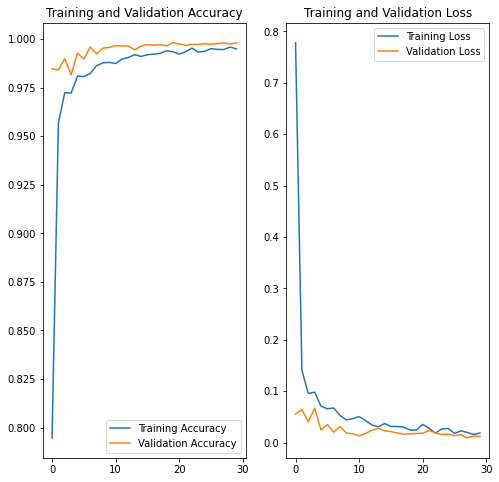

<Figure size 432x288 with 0 Axes>

In [186]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('cnn_accuracy.png')

In [176]:
test = pd.read_csv(DATA_DIR + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values
crop_coords = test[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

data = []
greyscale_data = []
crop_data = []
crop_grey_dat = []


#read in test data
for index, row in test.iterrows():
    try:
        image = cv2.imread(DATA_DIR + '/' + row['Path'])
        image_fromarray = Image.fromarray(image, 'RGB')
        cropped_img = image_fromarray.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        crop_resize = cropped_img.resize((IMG_HEIGHT, IMG_WIDTH))
        greyscale_img = ImageOps.grayscale(resize_image)
        crop_grey = ImageOps.grayscale(crop_resize)
        data.append(np.array(resize_image))
        greyscale_data.append(np.array(greyscale_img))
        crop_data.append(np.array(crop_resize))
        crop_grey_dat.append(np.array(crop_grey))
    except:
        print("Error in " + img)

X_test = np.array(data)
y_test = labels
grey_X_test = np.array(greyscale_data)
crop_X_test = np.array(crop_data)
crop_g_X_test = np.array(crop_grey_dat)


In [177]:
prediction = model.predict(x=X_test)
prediction
preds = np.argmax(prediction, axis=1)

In [179]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print(classification_report(test['ClassId'], preds))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        60
           1       0.93      0.99      0.96       720
           2       0.95      0.98      0.97       750
           3       0.99      0.96      0.97       450
           4       1.00      0.97      0.98       660
           5       0.98      0.96      0.97       630
           6       1.00      0.90      0.95       150
           7       0.99      0.90      0.94       450
           8       1.00      0.87      0.93       450
           9       0.99      0.96      0.97       480
          10       1.00      0.95      0.97       660
          11       0.93      0.96      0.94       420
          12       0.89      1.00      0.94       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.92      0.96       210
          16       1.00      1.00      1.00       150
          17       0.99    

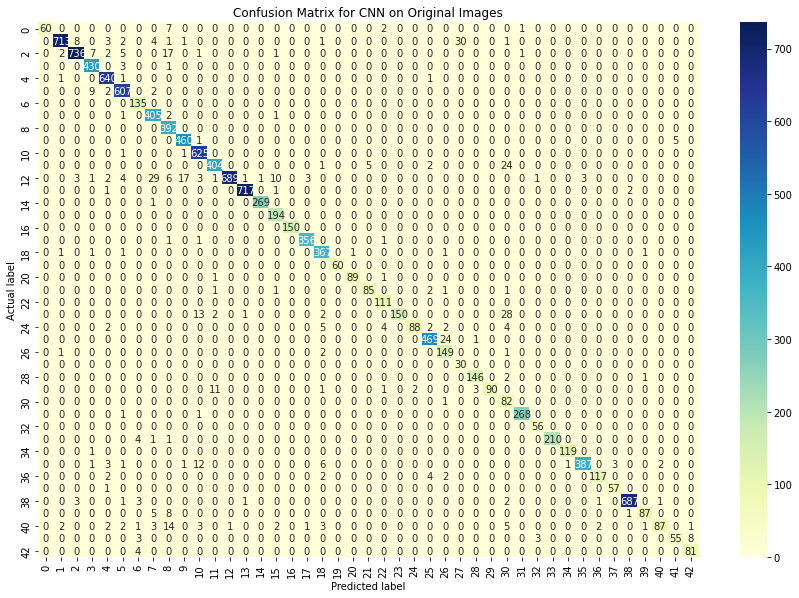

In [185]:
conf_mat_rf = confusion_matrix(preds, test['ClassId'])
classes = [0, 1]
plt.figure(figsize=(12,8))
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

sns.heatmap(pd.DataFrame(conf_mat_rf), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for CNN on Original Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('conf_mat_cnn.png')

In [182]:
report = classification_report(test['ClassId'], preds, output_dict=True)
df = pd.DataFrame(report).transpose()

In [183]:
df.head()

,precision,recall,f1-score,support
0,0.857143,1.000000,0.923077,60.0
1,0.933246,0.990278,0.960916,720.0
2,0.953368,0.981333,0.967148,750.0
3,0.990783,0.955556,0.972851,450.0
4,0.995334,0.969697,0.982348,660.0


In [184]:
df.to_csv('classification_report_cnn.csv')